In [65]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

SAMPLE_RATE = 16384
OVERLAP_FRACTION = 0.5
FRAME_LENGTH = 128
FRAME_STEP = int(FRAME_LENGTH * (1 - 0.25))
print(FRAME_STEP)
DATASET_PATH = "training_data"
data_dir = pathlib.Path(DATASET_PATH)

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != '_background_noise_') & (commands != 'LICENSE')]
print('Commands:', commands)



96
Commands: ['marvin' 'four' 'off' 'sheila' 'three' 'on' 'one' 'tree' 'house' 'yes'
 'testing_list.txt' 'go' 'stop' 'seven' 'right' 'left' 'no' 'happy' 'wow'
 'down' 'bed' 'two' 'eight' 'bird' 'five' 'validation_list.txt' 'dog'
 'cat' 'zero' 'up' 'six' 'nine']


In [66]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.25,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)


Found 64726 files belonging to 31 classes.
Using 48545 files for training.
Using 16181 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


In [67]:
train_ds.element_spec

(TensorSpec(shape=(None, 16384, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [68]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

#Data contains single channel audio, last dimension of the tensor can be dropped
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
train_ds.element_spec

(TensorSpec(shape=(None, 16384), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [69]:
#Split validation data set into validation and testing
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)


(64, 16384)
(64,)
['bed' 'bed' 'cat' '_background_noise_']


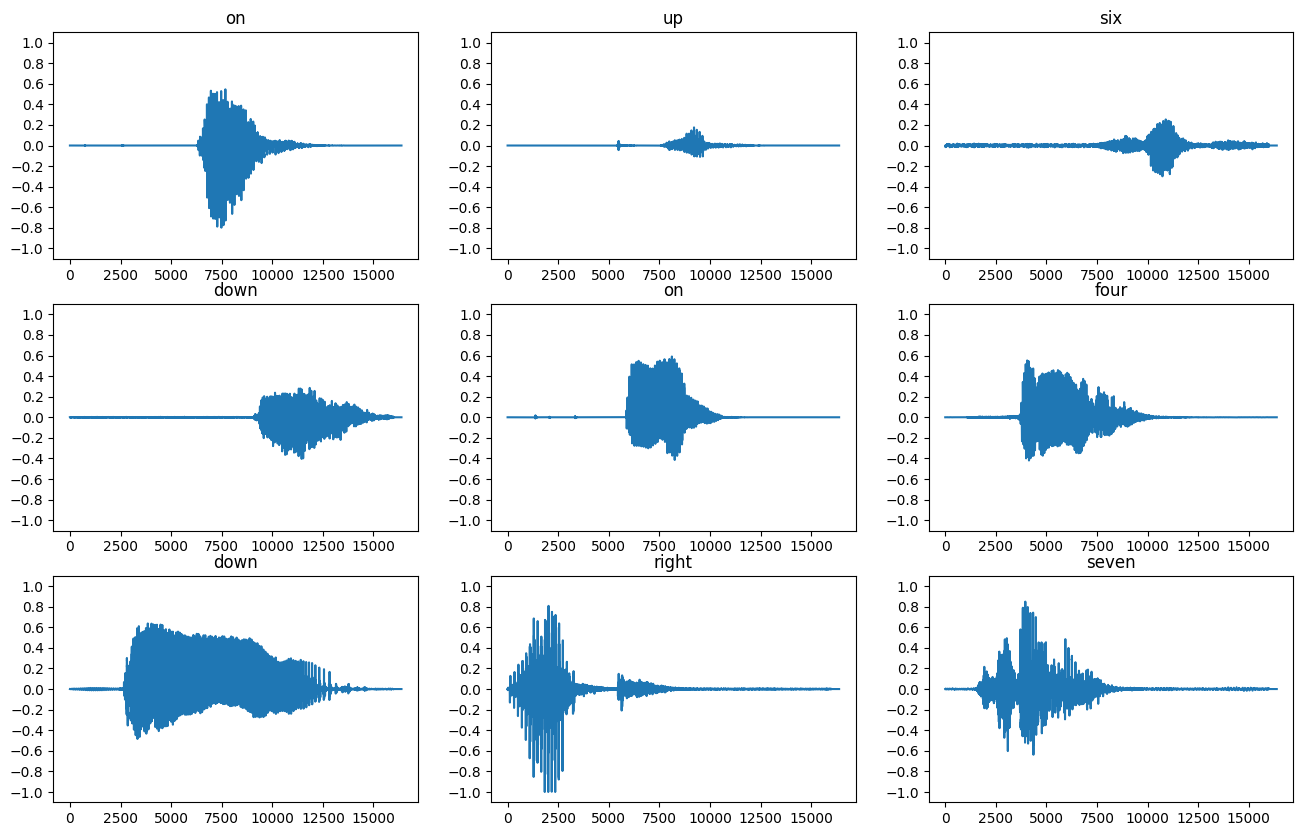

In [70]:

for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)


print(label_names[[1,1,3,0]])
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [71]:
def process_waveform(waveform):
  # window_size = FRAME_LENGTH
  # num_windows = len(waveform) // window_size
  # for i in range(num_windows):
  #   start_idx = i * window_size
  #   end_idx = (i + 1) * window_size

  #   # Extract the samples within the current window
  #   window_samples = waveform[start_idx:end_idx]
  #   # Calculate the mean value for the current window
  #   mean_value = np.mean(window_samples)
  #   # Subtract the mean value from each sample in the window
  #   window_samples -= mean_value
  #   # Find max value inside the window
  #   max_value = np.max(window_samples)
  #   # Subtract the max value from each sample in the window
  #   window_samples -= max_value
  #   # Update the original waveform with the modified window
  #   waveform[start_idx:end_idx] = window_samples
    

  return waveform



def get_spectrogram(waveform):

  waveform = process_waveform(waveform)
  
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [72]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  print(waveform)
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=SAMPLE_RATE))


tf.Tensor(
[ 0.0000000e+00 -3.0517578e-05 -6.1035156e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], shape=(16384,), dtype=float32)
Label: on
Waveform shape: (16384,)
Spectrogram shape: (170, 65, 1)
Audio playback


tf.Tensor(
[-3.0517578e-05 -9.1552734e-05 -3.0517578e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], shape=(16384,), dtype=float32)
Label: up
Waveform shape: (16384,)
Spectrogram shape: (170, 65, 1)
Audio playback


tf.Tensor(
[-0.00299072 -0.00421143 -0.00848389 ...  0.          0.
  0.        ], shape=(16384,), dtype=float32)
Label: six
Waveform shape: (16384,)
Spectrogram shape: (170, 65, 1)
Audio playback


In [73]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


170


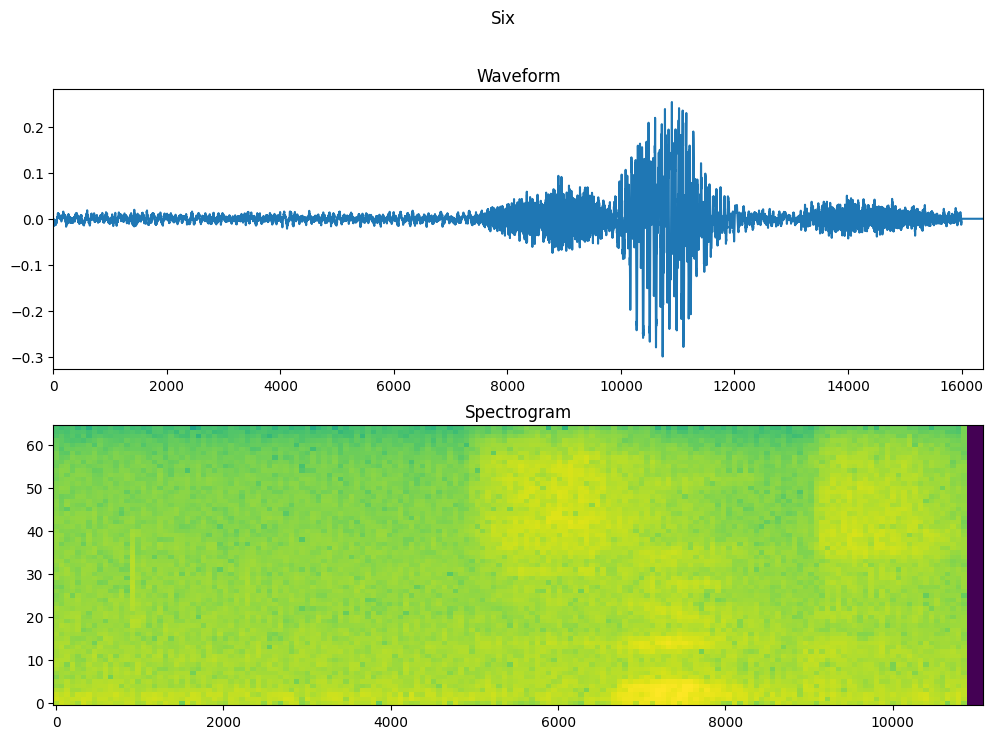

In [76]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, SAMPLE_RATE])

print(len(spectrogram.numpy()))
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()
